To Do:<br>Word Frequency cloud<br>
<br>On data cleanup, get locations and make plotly world bubble</br>

<h4>Data Source</h4>
This data was scraped from the trustpilot website, which could have been collected manually and required no additional access or sign up. In addition the scraper I used complied with their Robots.txt file. I do not wish to share the scraper code here out of respect for the website. They do run a proper API data feed with better information than we can scrape (importantly, user age and location) but it seems it is only available to their enterprise users.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS

#add to crawler - country on additional reviews page, not worth much as 90% of the reviews
#the majority of users only have one review, always access user's page and retreive location

df_users = pd.read_csv('/kaggle/input/asosrevs2/asosrevs2/user_info.csv')
df_users.columns = ['row-no','name','review count','userid']
df_asos = pd.read_csv('/kaggle/input/asosrevs2/asosrevs2/asos_reviews.csv')
df_asos.columns = ['row-no','rating','review body','review datetime','review title','userid']
df_supp = pd.read_csv('/kaggle/input/asosrevs2/asosrevs2/supplementary_reviews.csv')
df_supp.columns = ['row-no','rating','review body','review datetime','review title','userid']

In [2]:
df_asos['review datetime'] = pd.to_datetime(df_asos['review datetime'])

number of reviews 2016: 748


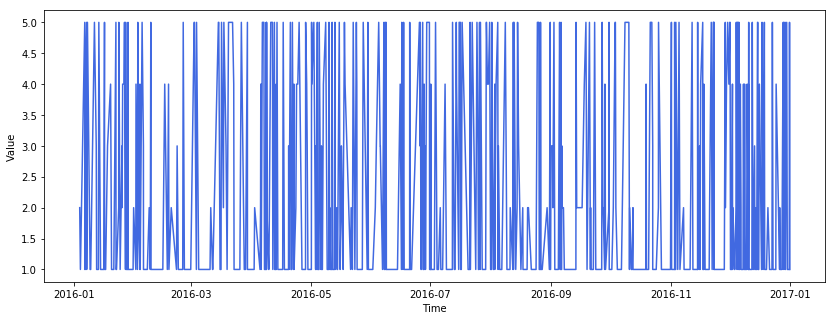

number of reviews 2017: 920


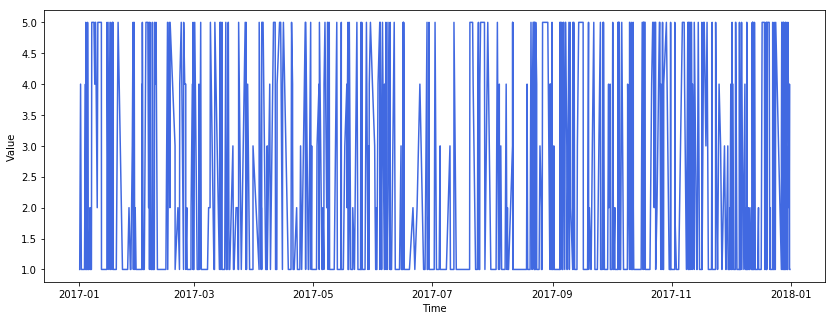

number of reviews 2018: 1734


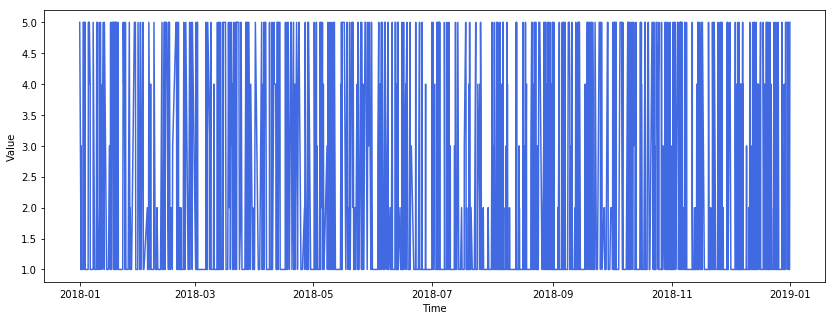

number of reviews 2019: 1580


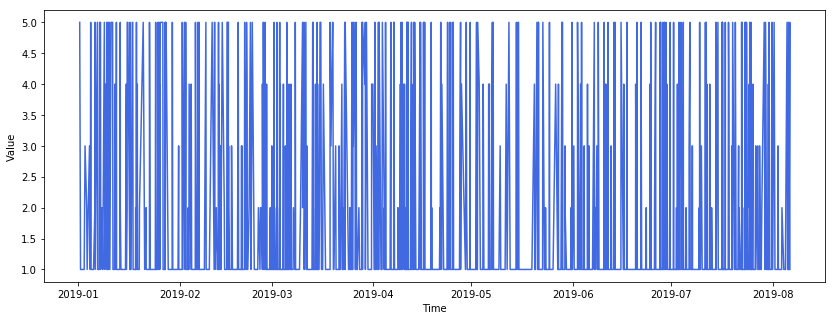

In [3]:
for i in range(2016,2020):
    print('number of reviews '+str(i)+':',
          len(df_asos.loc[df_asos['review datetime'].dt.year == i]['review datetime']))
    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(df_asos.loc[df_asos['review datetime'].dt.year == i]['review datetime'],
            df_asos.loc[df_asos['review datetime'].dt.year == i]['rating'], color='royalblue')
    plt.ylabel("Value")
    plt.xlabel("Time")
    plt.show()

There have been more reviews every year. Keeping that in mind, this looks relatively consistent. The parts where there are larger white gaps means there were only low scores during that period. That could be useful information for the business in identifying an issue and correcting it.

In [4]:
len(df_users.loc[df_users['review count'] > 1]) / len(df_users)

0.4872974594918984

Only 48.7% of the users who reviewed asos also reviewed at least 1 other company. This means something Asos is doing is driving people to sign up and review on trustpilot.

In [5]:
df_asos['hours'] = df_asos['review datetime'].dt.hour
df_asos['daylight'] = ((df_asos['hours'] >= 7) & (df_asos['hours'] <= 20)).astype(int)
df_asos['DayOfTheWeek'] = df_asos['review datetime'].dt.dayofweek
df_asos['WeekDay'] = (df_asos['DayOfTheWeek'] < 5).astype(int)

In [6]:
#make unix time epoch, easier for models to work with
df_asos['time_epoch'] = (df_asos['review datetime'].astype(np.int64)/100000000000).astype(np.int64)

In [7]:
#make categories for weekday or weekend, and day/night, 4 categories in total
df_asos['dnw_categ'] = df_asos['WeekDay']*2 + df_asos['daylight']

<h4>User Reviews and Reliability</h4>
Some ideas about the data are difficult to quantify numerically, here are some further assumptions about the data:<br>

<b>Survival Bias</b><br>
Customers who received good service are much less likely to review on trustpilot to begin with because they have nothing to gain from it, they 'survived' in a sense. This means many 'reviews' we end up with are just angry, emotional rants which may or may not have any logical reasoning behind them.

<b>Common Wrongly Identified Service Issues</b><br>
Users often rate the company they have made purchases from poorly (Asos in this instace), even though it is often a delivery firm to blame for 'poor service'. This unfairly reflects on a company receiving the bad review as there is little they can do about an external supplier such as a delivery firm, although many of their users perhaps do not think about this relationship. <br> 

<b>Problem Customers / Expectations too high</b><br>
Some people are impossible to please. If the purchase of products and services are <b>independent events</b>, then it is statistically very unlikely someone always receives poor service. If a person has left more than one review for a company or for several companies, and all or most of them are negative, it's likely this person is an unreliable reviewer and has unrealistically high expectations when purchasing services or goods. Their opinion should carry less weight.

<b>Fake Reviews</b><br>
Some reviews could be fake, and idicator for this would perhaps be if all of a users reviews are overly positive. This needs to be addressed.

<b>Problems and Solutions</b><br>

Some basic mathematics and averages should help us determine 'problem customers' and 'fake reviewers' based on ratings.NLP can be used to form a word cloud from the reviews, which will show us the biggest positives and negatives people mention. NLP may also be useful in identifying the sentiments behined the review texts and common problems which might help the company.

In [8]:
#unsurprisingly, the most common score is 1
print('most common score: ',df_supp['rating'].mode())

low_averages = []
high_averages = []
for user in df_users['userid']:
    review_score_average = df_supp.loc[df_supp['userid'] == user]['rating'].mean()
    if review_score_average < 2.5:
        low_averages.append((user,review_score_average))
    
    if review_score_average > 3.5:
        high_averages.append((user,review_score_average))

#These users have a consistently low score accross their reviews
#so are probably unreliable reviewers
#this much bad service is very unlikely if we consider each incident an independent event
#Additionally all except one have > 2 reviews, so there is a pattern of low scores
for user,score in low_averages:
    #df_users.loc[df_users['userid'] == user]
    print(user,score)
print("------------")
for user,score in high_averages:
    #df_users.loc[df_users['userid'] == user]
    print(user,score)

most common score:  0    1
dtype: int64
/users/548ae34800006400019cfe8e 1.6666666666666667
/users/51eee257000064000144fee4 2.2941176470588234
/users/5cac71809f582b4e77a632a6 2.4705882352941178
/users/5d2012d070bffde6ab4a0e61 2.361111111111111
/users/5b5271d74de5666d349e544c 2.4827586206896552
/users/54d0eb820000ff0001a87db1 2.4210526315789473
/users/5d3f5817f9c23501240ac625 2.479591836734694
/users/584f03330000ff000a60ed08 2.4375
/users/5c98a99454ea1f4679656e89 2.4012738853503186
/users/5d38b7cc6614ab90c0461540 2.48
/users/5a5796580000ff000affa94b 2.4419889502762433
/users/5c00fd59b0adce04ac11add2 2.4705882352941178
------------
/users/5c20bdfde550e1d6bef3e981 4.0


The above shows that there are a few 'problem customers' and very few people who are potentially posting 'fake' reviews, but not enough to be statistically significant. This is one concern taken care of.

In [9]:
df_asos = df_asos.sample(frac=1)
df_asos.head()

,row-no,rating,review body,review datetime,review title,userid,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,dnw_categ
3590,11,5,\n Favourite company to shop at! Be...,2017-10-17 11:37:52,\n Favourite company to shop at...,/users/5620bd340000ff0001e3679f,11,1,1,1,15082402,3
997,18,1,\n Absolutely terrible customer ser...,2019-04-08 09:36:57,\n Shocking customer service an...,/users/5c17974e81fa37d193f76167,9,1,0,1,15547162,3
3378,19,5,\n I have used ASOS for years and a...,2017-12-18 14:57:34,\n Cant fault them\n,/users/5841b9850000ff000a5d6f4e,14,1,0,1,15136090,3
2782,3,5,\n I place orders with ASOS frequen...,2018-05-30 20:50:24,\n My go to company for clothes...,/users/5b0f0d694de5666d34f38f69,20,1,2,1,15277134,3
1595,16,1,\n DO NOT ORDER FROM THIS PLACE. TH...,2018-12-28 19:30:33,\n DO NOT ORDER FROM THIS PLACE...,/users/5c2679cfb1584a7923551625,19,1,4,1,15460254,3


<h4>Review difference by day/night, weekday/weekend, and distribution</h4>

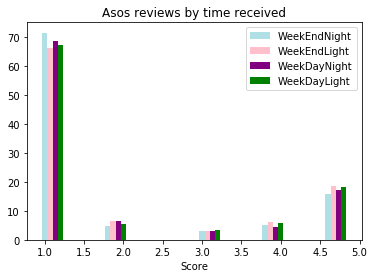

In [10]:
a = df_asos.loc[df_asos['dnw_categ'] == 0, 'rating']
b = df_asos.loc[df_asos['dnw_categ'] == 1, 'rating']
c = df_asos.loc[df_asos['dnw_categ'] == 2, 'rating']
d = df_asos.loc[df_asos['dnw_categ'] == 3, 'rating']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width,
       facecolor='powderblue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width,
       facecolor='pink', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width,
       facecolor='purple', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width,
       facecolor='green', label ='WeekDayLight')

plt.title('Asos reviews by time received')
plt.xlabel('Score')
plt.legend()
plt.show()

Overwhelmingly the most common review score is 1, regardless the day or night or weekend. Just barely, the most 1 star reviews occur on weekend night times. Proportionally speaking the most positive scores, 5 star reviews, occur in the week during the day time.

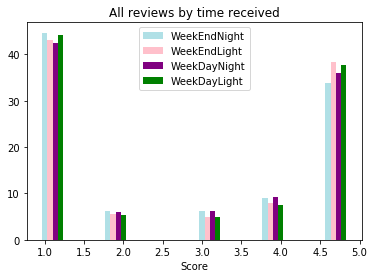

In [11]:
df_supp['review datetime'] = pd.to_datetime(df_supp['review datetime'])
df_supp['hours'] = df_supp['review datetime'].dt.hour
df_supp['daylight'] = ((df_supp['hours'] >= 7) & (df_supp['hours'] <= 20)).astype(int)
df_supp['DayOfTheWeek'] = df_supp['review datetime'].dt.dayofweek
df_supp['WeekDay'] = (df_supp['DayOfTheWeek'] < 5).astype(int)
df_supp['dnw_categ'] = df_supp['WeekDay']*2 + df_supp['daylight']

a = df_supp.loc[df_supp['dnw_categ'] == 0, 'rating']
b = df_supp.loc[df_supp['dnw_categ'] == 1, 'rating']
c = df_supp.loc[df_supp['dnw_categ'] == 2, 'rating']
d = df_supp.loc[df_supp['dnw_categ'] == 3, 'rating']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width,
       facecolor='powderblue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width,
       facecolor='pink', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width,
       facecolor='purple', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width,
       facecolor='green', label ='WeekDayLight')

plt.title('All reviews by time received')
plt.xlabel('Score')
plt.legend()
plt.show()

There is a similar pattern as before for 'all reviews', which are the supplementary reviews associated with the users who left asos a review. The difference is that the general reviews are much more positive with many more 5 star reviews, relatively speaking.
<h4>Takeaway from these group frequencies?</h4>
Given there are comparitively more 5 stars reviews amongst the same set of users for other services, it isn't unreasonable to beleive there could be issues and this isn't just people complaining over nothing.

<h2>Natural Language Processing (NLP)</h2>
<h4>Lazy Labeling</h4>
I have decided to label the sentiment of the reviews as follows, based on their rating. This seems sensible since someone who has given 5 stars is unlikely to have left a negative comment, and vice-versa:<br><br>
1 - 2 stars, Negative<br>
3 stars, Neutral<br>
4 -5 stars, Positive<br>

After the data is labelled I will produce a word cloud, so we can see how much of a problem things like delivery crop up in the negative reviews. We will also be able to see what people like about the company.

In [12]:
def getSentiment(rating):
    if rating == 1 or rating == 2:
        return 'Negative'
    if rating == 3:
        return 'Neutral'
    if rating == 4 or rating == 5:
        return 'Positive'
    #should never happen, but the fall through is that it should make no difference
    return 'Neutral'

df_asos['sentiment'] = [getSentiment(x) for x in df_asos['rating']]
df_asos.head()

,row-no,rating,review body,review datetime,review title,userid,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,dnw_categ,sentiment
3590,11,5,\n Favourite company to shop at! Be...,2017-10-17 11:37:52,\n Favourite company to shop at...,/users/5620bd340000ff0001e3679f,11,1,1,1,15082402,3,Positive
997,18,1,\n Absolutely terrible customer ser...,2019-04-08 09:36:57,\n Shocking customer service an...,/users/5c17974e81fa37d193f76167,9,1,0,1,15547162,3,Negative
3378,19,5,\n I have used ASOS for years and a...,2017-12-18 14:57:34,\n Cant fault them\n,/users/5841b9850000ff000a5d6f4e,14,1,0,1,15136090,3,Positive
2782,3,5,\n I place orders with ASOS frequen...,2018-05-30 20:50:24,\n My go to company for clothes...,/users/5b0f0d694de5666d34f38f69,20,1,2,1,15277134,3,Positive
1595,16,1,\n DO NOT ORDER FROM THIS PLACE. TH...,2018-12-28 19:30:33,\n DO NOT ORDER FROM THIS PLACE...,/users/5c2679cfb1584a7923551625,19,1,4,1,15460254,3,Negative


<h3>Word Clouds</h3>

Positive words


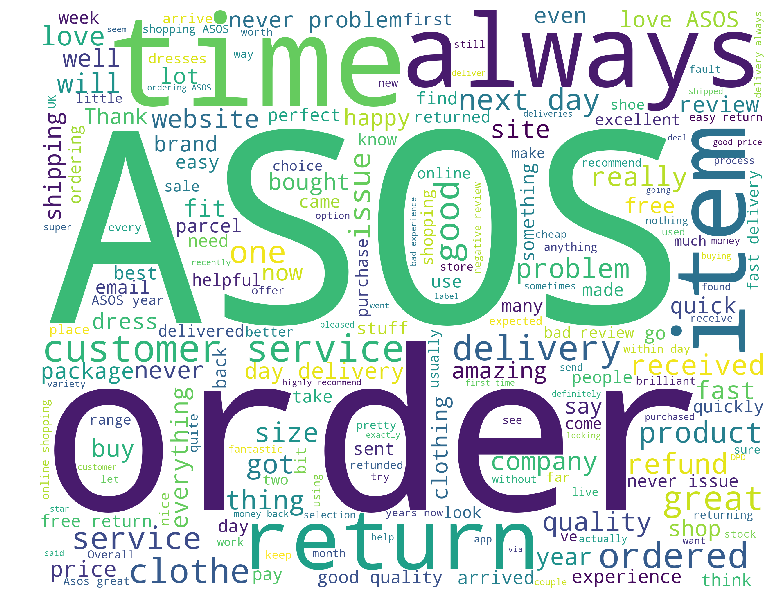

In [13]:
train_pos = df_asos.loc[df_asos['sentiment'] == 'Positive']['review body']
#train_pos = train_pos['review body']
train_neg = df_asos.loc[df_asos['sentiment'] == 'Negative']['review body']
#train_neg = train_neg['review body']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')

Amongst the positive reviews it seems the brand is very strong, being the biggest word here. Other things which people seem to like are the <b>returns and refunds</b>, as well as the word <b>"Always"</b>, which suggests a consistent and reliable service.

Negative words


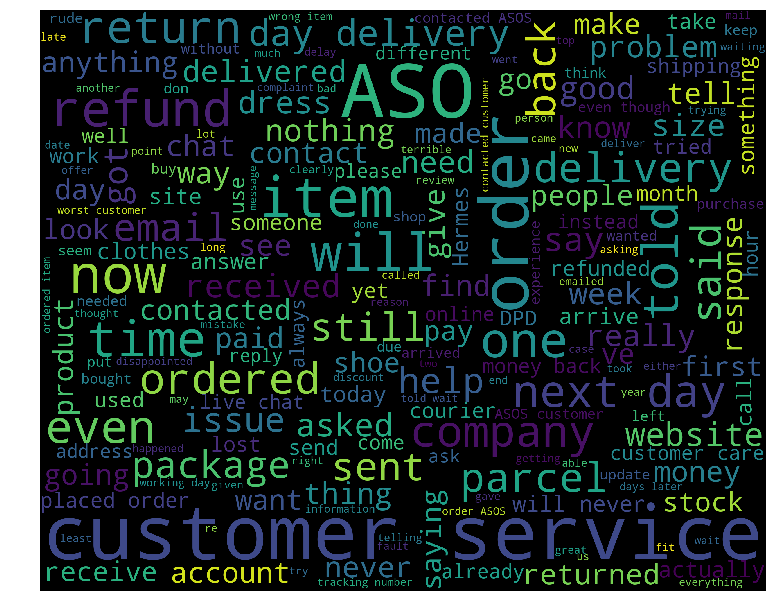

In [14]:
print("Negative words")
wordcloud_draw(train_neg)

The biggest issue which jumps out is <b>Customer Service</b> and other issues related to that such as <b>Contact and Contacted, Live Chat</b>. Aside from those, The second biggest issues seem to be <b>Delivery</b> related and associated words such as <b>Parcel, Package, next day, time, day, DPD, Hermes</b>.<br>

My own take on this is that the typical customers who bother to leave the reviews probably don't get their order at the estimated time. They have paid for delivery and expect it to be honoured. Users then contact Asos customer services who probably don't have any more information than the customer and just get shouted at all day by customers, so the service agents probably don't give their best all the time as they themselves are unhappy. It seems difficult for the company to deal with this as it seems most of their issues are due to <b>external suppliers</b> (delivery companies), and even using various delivery companies does not seem to help as there are various ones mentioned in this cloud.

<h3>Word frequency cloud (StopWords removed)</h3>